# 03 Classification of synthetic time series data
Following on from notebook 02, we aim to classify the time series generated with an ML algorithm e.g, Support Vector Machine (SVM), and they need to be similar enough to be difficult to classify.

## Import functions from the ``src`` folder

The functions to run the simulations are already in the ``src`` folder in the root directory of this repository. All we have to do is to import them in order to use them.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tqdm
from sympy import sqrt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# Import all the functions from the 'src' directory, we import all the functions from each module so we can use them straight away
from ssa_simulation import simulate_two_telegraph_model_systems
from ssa_analysis import find_steady_state, statistical_report, plot_mRNA_trajectory, plot_mRNA_variance, plot_mRNA_dist
from ssa_classification import *
from TODO_ssa_autocorrelation import autocrosscorr
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulate two different systems with the same mean so that the 2 time series are similar

**The telegraph model:**

$$
G^{\star} \xrightleftharpoons[\sigma_{\text{u}}]{\sigma_{\text{b}}} G \xrightarrow{\rho} G + M, \quad M \xrightarrow{d} \emptyset
$$

**System 1:** Normal Condition (σ_u_normal = 9.0, σ_b_normal = 0.02)

**System 2:** Stressed Condition (σ_u_stress = 18.0, σ_b_stress = 0.01)

- Higher gene deactivation rate: genes encoding metabolic enzymes under stress do not stay active for long.
- Lower gene activation rate: stress often results in strong repression of transcription by repressors, which makes gene activation rarer.
This combination will lead to lower mRNA levels.

**Theoretical foundation:**

The equation for the mean mRNA levels at steady state, in terms of the system parameters, is:

$$ \mu = \frac{\sigma_b \rho}{d (\sigma_b + \sigma_u)} $$

The equation for the mRNA level variance at steady state, in terms of the system parameters, is: 

$$ \sigma ^2 = \frac{\sigma_b \rho}{d (\sigma_b + \sigma_u)} + \frac{\sigma_u \sigma_b}{({\sigma_u + \sigma_b})^2} \frac{\rho^2}{d(\sigma_u + \sigma_b + d)} $$

From these equations, we can fix the mean or variance to be the same by moving the terms around. Below is an example, to **fix the mean of the mRNA levels**. 

In [ ]:
# Define system parameters
mu_target = 10.0  

# Define activation/deactivation rates for two conditions
sigma_u_stress, sigma_b_stress = 18.0, 0.01  # Stressed Condition
sigma_u_normal, sigma_b_normal = 9.0, 0.02   # Normal Condition

# Define degradation rates
d_stress = d_normal = 0.12

# Compute corresponding transcription rates (rho) using the given formula
rho_stress = (mu_target * d_stress * (sigma_u_stress + sigma_b_stress)) / sigma_b_stress
rho_normal = (mu_target * d_normal * (sigma_u_normal + sigma_b_normal)) / sigma_b_normal

# Updated parameter sets ensuring similar mean mRNA levels
parameter_sets = [
    {"sigma_u": sigma_u_stress, "sigma_b": sigma_b_stress, "rho": rho_stress, "d": d_stress, "label": 0},
    {"sigma_u": sigma_u_normal, "sigma_b": sigma_b_normal, "rho": rho_normal, "d": d_normal, "label": 1},
]

# Set up simulation parameters 
# !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
# 144 time points: to match experimental conditions, where typically a photo is taken every 5 min over 12 hours --> 144 time points

size = 200  # Reduce number of simulations per condition for efficiency

# Run the simulation function
df_results = simulate_two_telegraph_model_systems(parameter_sets, time_points, size)

# Save dataset for ML classification
output_file = "traj_data/mRNA_trajectories_mean_fixed.csv"
df_results.to_csv(output_file, index=False)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# report the mean and variance of the mRNA counts at steady state
report = statistical_report(parameter_sets, stress_trajectories, normal_trajectories)

Simulating Telegraph Model Systems:   0%|          | 0/2 [00:00<?, ?it/s]

Simulating Telegraph Model Systems:  50%|█████     | 1/2 [00:01<00:01,  1.90s/it]

✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 13.0 min):
    - Mean mRNA Count: 11.91
    - Variance: 1264.84

  Normal Condition (after 12.0 min):
    - Mean mRNA Count: 11.28
    - Variance: 620.08


Visualise the time series generated - they should be quite similar

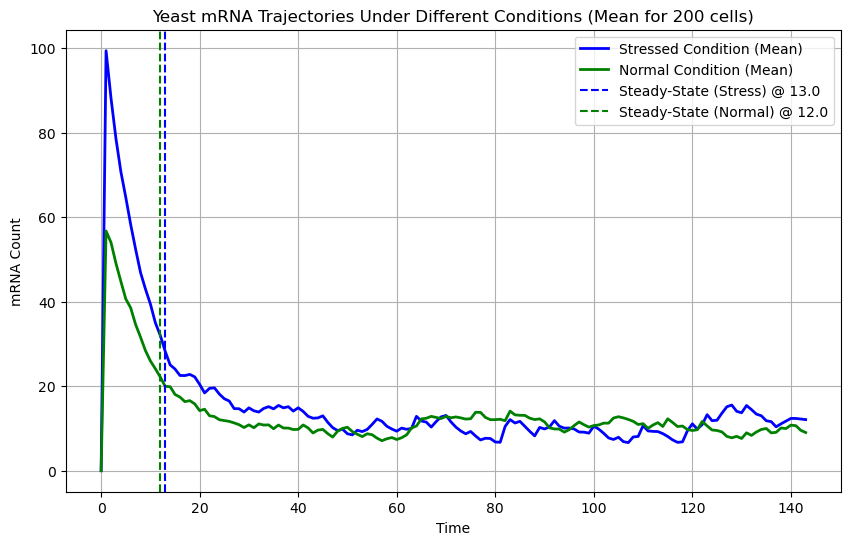

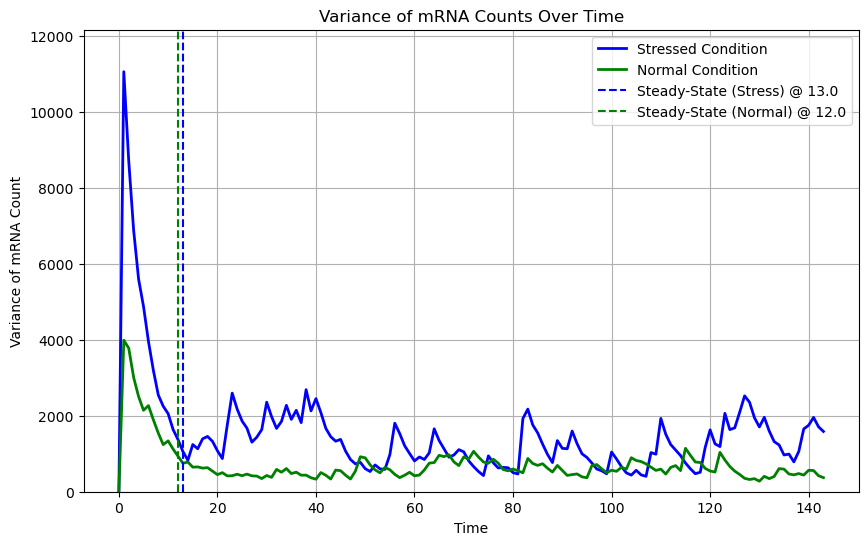


=== Variance at Steady State ===
  Stressed Condition (after 13.0 min): Mean = 12.06, Variance = 1274.49
  Normal Condition (after 12.0 min): Mean = 11.11, Variance = 599.26


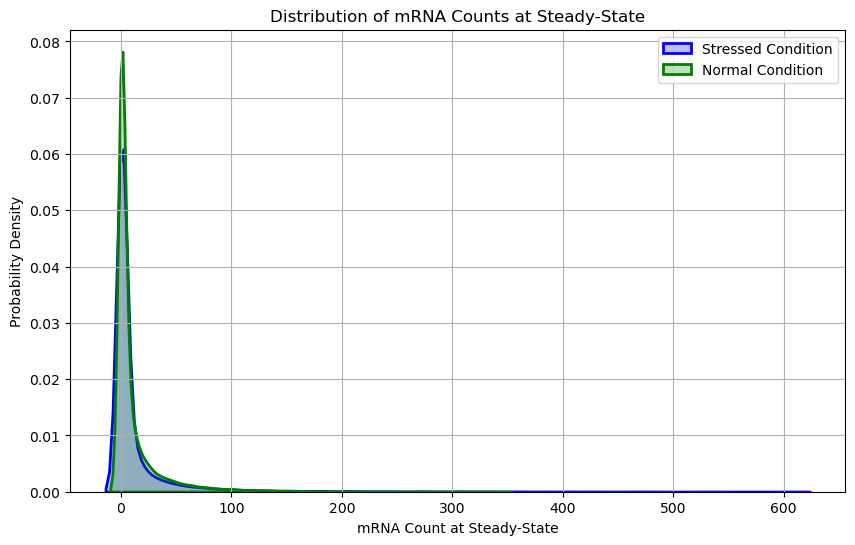

In [ ]:
# Plots
plot_mRNA_trajectory(time_points, stress_trajectories, normal_trajectories)
plot_mRNA_variance(time_points, stress_trajectories, normal_trajectories)
plot_mRNA_dist(time_points, stress_trajectories, normal_trajectories)

SVM to classify the two different environments, ideally we'd like to make things difficult for them to distinguish

=== SVM Classification Accuracy: 0.59 ===
=== Random Forest Accuracy: 0.61 ===
=== Logistic Regression Accuracy: 0.57 ===
=== Random Classifier Accuracy: 0.50 ===


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


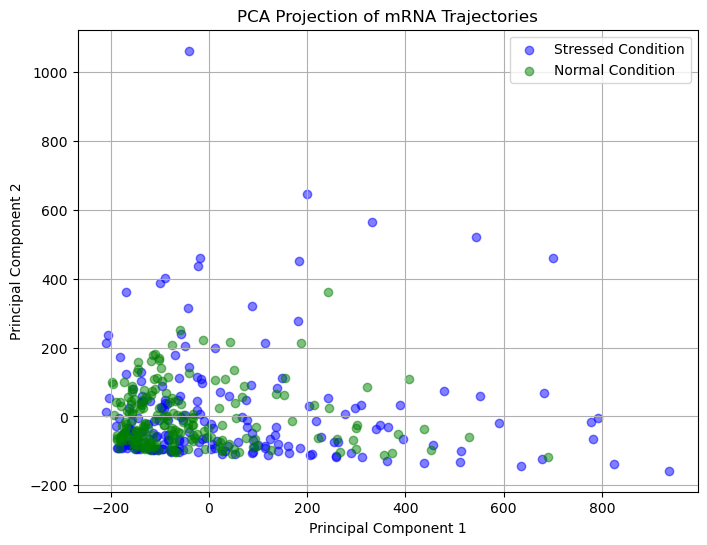

In [27]:
output_file = "traj_data/mRNA_trajectories_mean_fixed.csv"
X_train, X_test, y_train, y_test = load_and_split_data(output_file)
svm_accuracy = svm_classifier(X_train, X_test, y_train, y_test)
rf_accuracy = random_forest_classifier(X_train, X_test, y_train, y_test)
log_reg_accuracy = logistic_regression_classifier(X_train, X_test, y_train, y_test)
random_accuracy = random_classifier(y_test)
pca_plot(output_file)

<span style='color: red'>Cross-correlation between the 2 signals</span>

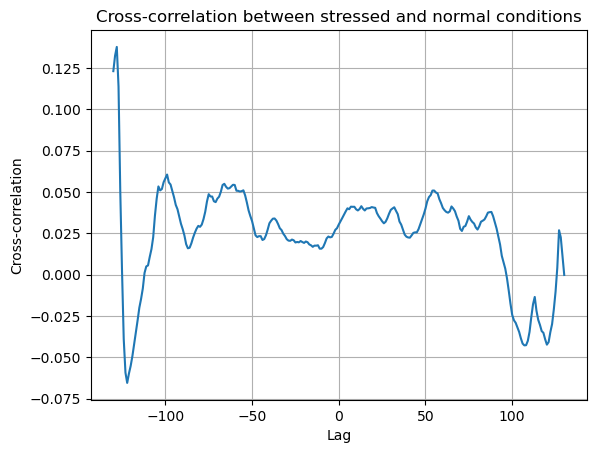

In [18]:
output_file = "traj_data/mRNA_trajectories_mean_fixed.csv"
df_results = pd.read_csv(output_file)
# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition
# Compute mean trajectories
mean_stress = stress_trajectories.mean(axis=0)
mean_normal = normal_trajectories.mean(axis=0)

# Find steady-state time points
ss_time_stress, ss_index_stress = find_steady_state(time_points, mean_stress)
ss_time_normal, ss_index_normal = find_steady_state(time_points, mean_normal)

# Extract steady-state portions
stress_ss_data = stress_trajectories[:, ss_index_stress:]
normal_ss_data = normal_trajectories[:, ss_index_stress:]

# Find and plot the cross-correlation between the two conditions
ac, lags = autocrosscorr(yA=normal_ss_data, yB=stress_ss_data)
plt.figure()
plt.plot(lags, np.nanmean(ac, axis=0))
plt.xlabel("Lag")
plt.ylabel("Cross-correlation")
plt.title("Cross-correlation between stressed and normal conditions")
plt.grid()
plt.show()


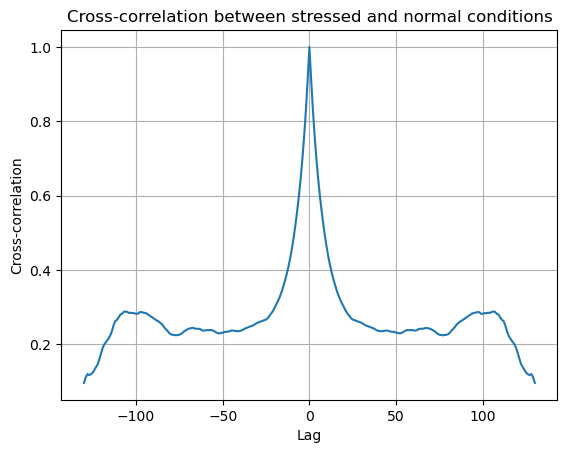

In [17]:
output_file = "traj_data/mRNA_trajectories_mean_fixed.csv"
df_results = pd.read_csv(output_file)
# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition
# Compute mean trajectories
mean_stress = stress_trajectories.mean(axis=0)
mean_normal = normal_trajectories.mean(axis=0)

# Find steady-state time points
ss_time_stress, ss_index_stress = find_steady_state(time_points, mean_stress)
ss_time_normal, ss_index_normal = find_steady_state(time_points, mean_normal)

# Extract steady-state portions
stress_ss_data = stress_trajectories[:, ss_index_stress:]
normal_ss_data = normal_trajectories[:, ss_index_stress:]

# Find and plot the cross-correlation between the two conditions
ac, lags = autocrosscorr(yA=stress_ss_data)
plt.figure()
plt.plot(lags, np.nanmean(ac, axis=0))
plt.xlabel("Lag")
plt.ylabel("Cross-correlation")
plt.title("Cross-correlation between stressed and normal conditions")
plt.grid()
plt.show()


## Fixing the Variance of mRNA counts
Fix the **variance** to be at a known value, using the equation 

$$ \sigma ^2 = \frac{\sigma_b \rho}{d (\sigma_b + \sigma_u)} + \frac{\sigma_u \sigma_b}{({\sigma_u + \sigma_b})^2} \frac{\rho^2}{d(\sigma_u + \sigma_b + d)} $$

Solving it for $ \rho $ using Mathematica, we get the following *positive* solution:

$$
\rho = -\frac{(\sigma_b + \sigma_u) \sqrt{ d + \sigma_b + \sigma_u} (\sqrt{\sigma_b} \sqrt{d + \sigma_b + \sigma_u} - \sqrt{\sigma_b (\sigma_b + \sigma_u) + d (\sigma_b + 4 \sigma ^2 \sigma_u)}
    )}{2 \sqrt{\sigma_b} \sigma_u}

$$

<!-- Initially, I used the sympy module from python to do the work for me, but I'm not convinced by its answers.

from sympy import symbols, Eq, solve

# Define variables
sigma_sq, sigma_b, sigma_u, rho, d = symbols('variance_target sigma_b sigma_u rho d')

# Define the given equation
eq = Eq(
    sigma_sq, 
    (sigma_b * rho) / (d * (sigma_b + sigma_u)) + 
    (sigma_u * sigma_b / (sigma_u + sigma_b)**2) * (rho**2 / (d * (sigma_u + sigma_b + d)))
)

# Solve for rho
rho_solution = solve(eq, rho)
rho_solution
 -->

Variance of both systems to be the same

Simulating Telegraph Model Systems:   0%|          | 0/2 [00:00<?, ?it/s]

Simulating Telegraph Model Systems:  50%|█████     | 1/2 [00:25<00:25, 25.23s/it]

✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:57<00:00, 28.83s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 4.16
    - Variance: 1372.79

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.45
    - Variance: 1205.37
=== SVM Classification Accuracy: 0.61 ===


=== Random Forest Accuracy: 0.66 ===
=== Logistic Regression Accuracy: 0.53 ===
=== Random Classifier Accuracy: 0.53 ===


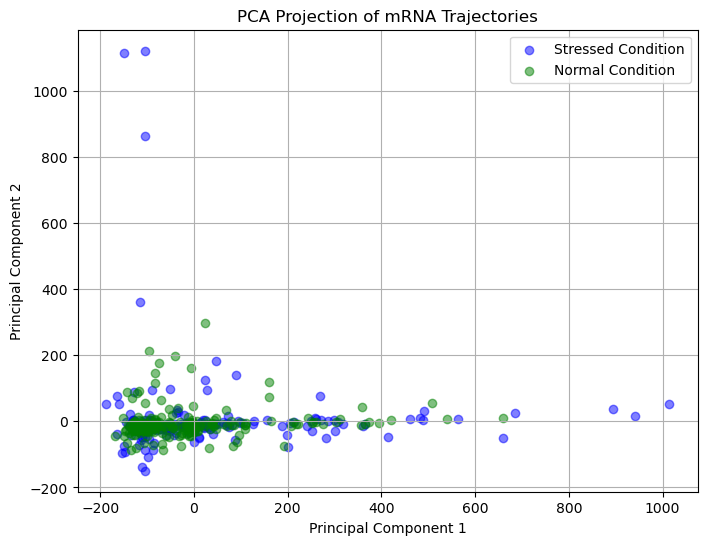

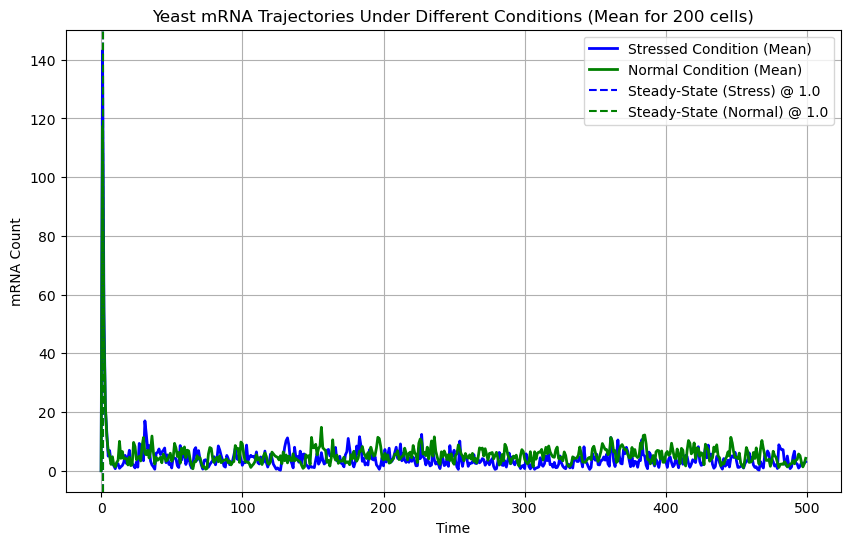

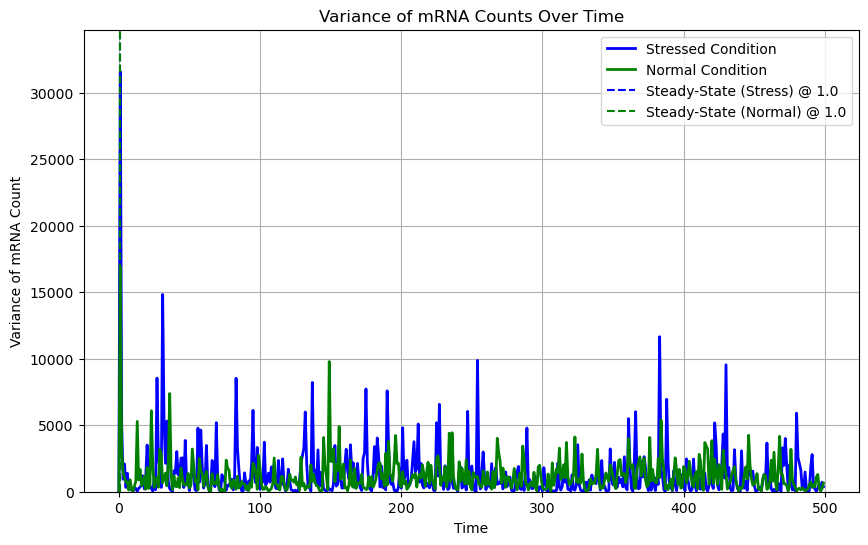


=== Variance at Steady State ===
  Stressed Condition (after 1.0 min): Mean = 4.16, Variance = 1368.29
  Normal Condition (after 1.0 min): Mean = 5.43, Variance = 1202.34


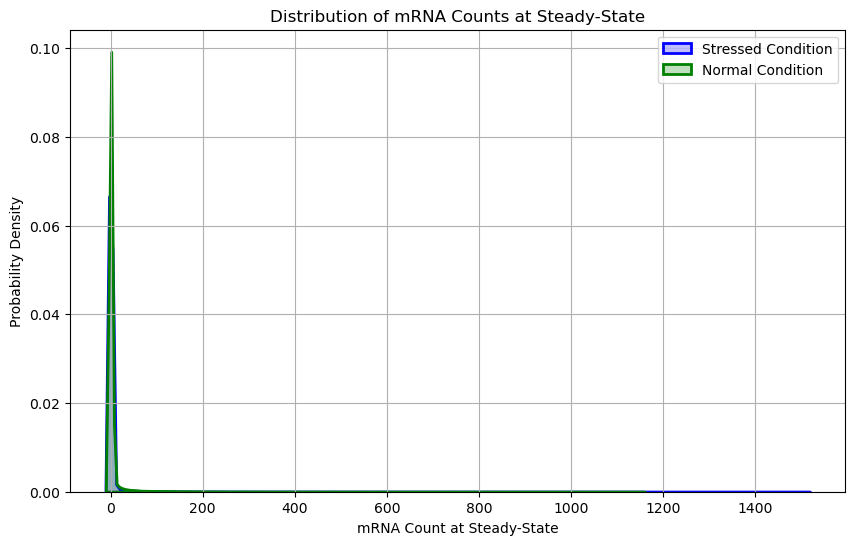

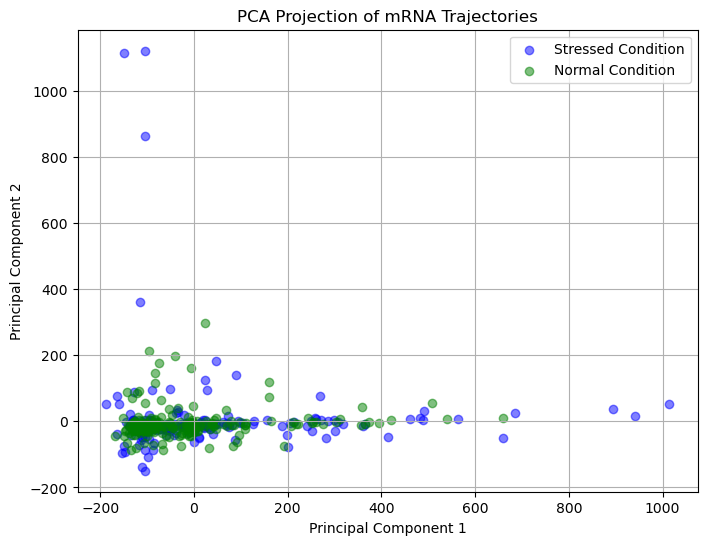

In [ ]:
# Define system parameters
variance_target_stress = 1200.0  
variance_target_normal = 1200.0

# Define activation/deactivation rates for two conditions
sigma_u_stress, sigma_b_stress = 18.0, 0.01  # Stressed Condition
sigma_u_normal, sigma_b_normal = 9.0, 0.02   # Normal Condition

# Define degradation rates
d_stress = d_normal = 1

# Compute corresponding transcription rates (rho) using the given formula for variance
# Compute rho for stress condition using Mathematica's first solution
rho_stress = - (sigma_b_stress + sigma_u_stress) * sqrt(d_stress + sigma_b_stress + sigma_u_stress) * (sqrt(sigma_b_stress) * sqrt(d_stress + sigma_b_stress + sigma_u_stress) -sqrt(sigma_b_stress * (sigma_b_stress + sigma_u_stress) + d_stress * (sigma_b_stress + 4 * variance_target_stress * sigma_u_stress))) / (2 * sqrt(sigma_b_stress) * sigma_u_stress)

# Compute rho for normal condition using Mathematica's first solution
rho_normal = - (sigma_b_normal + sigma_u_normal) * sqrt(d_normal + sigma_b_normal + sigma_u_normal) * (sqrt(sigma_b_normal) * sqrt(d_normal + sigma_b_normal + sigma_u_normal) -sqrt(sigma_b_normal * (sigma_b_normal + sigma_u_normal) + d_normal * (sigma_b_normal + 4 * variance_target_normal * sigma_u_normal))) / (2 * sqrt(sigma_b_normal) * sigma_u_normal)

# Updated parameter sets ensuring similar mean mRNA levels
parameter_sets = [
    {"sigma_u": sigma_u_stress, "sigma_b": sigma_b_stress, "rho": rho_stress, "d": d_stress, "label": 0},
    {"sigma_u": sigma_u_normal, "sigma_b": sigma_b_normal, "rho": rho_normal, "d": d_normal, "label": 1},
]

# Set up simulation parameters 
# !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
time_points = np.arange(0, 500.0, 1.0)  # Time range: start, stop, step; 
# 144 time points: to match experimental conditions, where typically a photo is taken every 5 min over 12 hours --> 144 time points

size = 200  # size of the simulation needs to be big enough for this particular system to reach steady state

# Run the simulation function
df_results = simulate_two_telegraph_model_systems(parameter_sets, time_points, size)

# Save dataset for ML classification
output_file = f"traj_data/mRNA_trajectories_variance_fixed_{variance_target_stress}_{variance_target_normal}.csv"
df_results.to_csv(output_file, index=False)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# report the mean and variance of the mRNA counts at steady state
report =  statistical_report(parameter_sets, stress_trajectories, normal_trajectories)
X_train, X_test, y_train, y_test = load_and_split_data(output_file)
svm_accuracy = svm_classifier(X_train, X_test, y_train, y_test)
rf_accuracy = random_forest_classifier(X_train, X_test, y_train, y_test)
log_reg_accuracy = logistic_regression_classifier(X_train, X_test, y_train, y_test)
random_accuracy = random_classifier(y_test)
pca_plot(output_file)

# Plots
plot_mRNA_trajectory(time_points, stress_trajectories, normal_trajectories)
plot_mRNA_variance(time_points, stress_trajectories, normal_trajectories)
plot_mRNA_dist(time_points, stress_trajectories, normal_trajectories)
pca_plot(output_file)

Change the variance ratio over a range, then plot Variance Ratio VS. Prediction Accuracy (SVM, Random Forest, Logistic Regression and Random Classifier)

Running Variance Ratio Simulations:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:43<00:00, 21.99s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 2.94
    - Variance: 661.54

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.40
    - Variance: 1218.43
=== SVM Classification Accuracy: 0.70 ===



/localdisk/home/s1732775/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Running Variance Ratio Simulations:   2%|▏         | 1/50 [00:44<36:16, 44.42s/it]

=== Random Forest Accuracy: 0.78 ===
=== Logistic Regression Accuracy: 0.47 ===
=== Random Classifier Accuracy: 0.50 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:41<00:00, 20.67s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 2.80
    - Variance: 673.57

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.46
    - Variance: 1158.02
=== SVM Classification Accuracy: 0.71 ===



Running Variance Ratio Simulations:   4%|▍         | 2/50 [01:26<34:18, 42.89s/it]

=== Random Forest Accuracy: 0.69 ===
=== Logistic Regression Accuracy: 0.57 ===
=== Random Classifier Accuracy: 0.49 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:43<00:00, 21.55s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 3.16
    - Variance: 800.41

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.52
    - Variance: 1275.48
=== SVM Classification Accuracy: 0.56 ===



Running Variance Ratio Simulations:   6%|▌         | 3/50 [02:09<33:48, 43.16s/it]

=== Random Forest Accuracy: 0.65 ===
=== Logistic Regression Accuracy: 0.47 ===
=== Random Classifier Accuracy: 0.34 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:41<00:00, 20.64s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 3.00
    - Variance: 772.65

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.25
    - Variance: 1177.71
=== SVM Classification Accuracy: 0.68 ===



Running Variance Ratio Simulations:   8%|▊         | 4/50 [02:51<32:38, 42.58s/it]

=== Random Forest Accuracy: 0.68 ===
=== Logistic Regression Accuracy: 0.60 ===
=== Random Classifier Accuracy: 0.59 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:43<00:00, 21.74s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 3.41
    - Variance: 890.11

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.49
    - Variance: 1237.34
=== SVM Classification Accuracy: 0.71 ===



/localdisk/home/s1732775/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Running Variance Ratio Simulations:  10%|█         | 5/50 [03:35<32:16, 43.04s/it]

=== Random Forest Accuracy: 0.60 ===
=== Logistic Regression Accuracy: 0.56 ===
=== Random Classifier Accuracy: 0.55 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:42<00:00, 21.43s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 3.50
    - Variance: 940.62

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.53
    - Variance: 1186.56
=== SVM Classification Accuracy: 0.61 ===



/localdisk/home/s1732775/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Running Variance Ratio Simulations:  12%|█▏        | 6/50 [04:18<31:36, 43.11s/it]

=== Random Forest Accuracy: 0.69 ===
=== Logistic Regression Accuracy: 0.47 ===
=== Random Classifier Accuracy: 0.57 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:42<00:00, 21.19s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 3.43
    - Variance: 994.36

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.59
    - Variance: 1286.56
=== SVM Classification Accuracy: 0.59 ===



/localdisk/home/s1732775/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Running Variance Ratio Simulations:  14%|█▍        | 7/50 [05:01<30:48, 42.99s/it]

=== Random Forest Accuracy: 0.74 ===
=== Logistic Regression Accuracy: 0.56 ===
=== Random Classifier Accuracy: 0.54 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:42<00:00, 21.14s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 3.71
    - Variance: 1066.91

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.24
    - Variance: 1183.65
=== SVM Classification Accuracy: 0.66 ===



Running Variance Ratio Simulations:  16%|█▌        | 8/50 [05:43<30:02, 42.91s/it]

=== Random Forest Accuracy: 0.70 ===
=== Logistic Regression Accuracy: 0.59 ===
=== Random Classifier Accuracy: 0.45 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:45<00:00, 22.87s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 4.02
    - Variance: 1236.34

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.40
    - Variance: 1215.21
=== SVM Classification Accuracy: 0.59 ===



/localdisk/home/s1732775/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Running Variance Ratio Simulations:  18%|█▊        | 9/50 [06:30<30:01, 43.93s/it]

=== Random Forest Accuracy: 0.64 ===
=== Logistic Regression Accuracy: 0.54 ===
=== Random Classifier Accuracy: 0.47 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:46<00:00, 23.04s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 3.81
    - Variance: 1147.37

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.40
    - Variance: 1155.91
=== SVM Classification Accuracy: 0.61 ===



/localdisk/home/s1732775/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Running Variance Ratio Simulations:  20%|██        | 10/50 [07:16<29:48, 44.72s/it]

=== Random Forest Accuracy: 0.72 ===
=== Logistic Regression Accuracy: 0.55 ===
=== Random Classifier Accuracy: 0.44 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:45<00:00, 22.98s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 4.21
    - Variance: 1325.98

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.57
    - Variance: 1278.31
=== SVM Classification Accuracy: 0.59 ===



Running Variance Ratio Simulations:  22%|██▏       | 11/50 [08:02<29:23, 45.21s/it]

=== Random Forest Accuracy: 0.70 ===
=== Logistic Regression Accuracy: 0.60 ===
=== Random Classifier Accuracy: 0.46 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:44<00:00, 22.48s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 4.19
    - Variance: 1400.95

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.27
    - Variance: 1189.14
=== SVM Classification Accuracy: 0.53 ===



Running Variance Ratio Simulations:  24%|██▍       | 12/50 [08:48<28:40, 45.27s/it]

=== Random Forest Accuracy: 0.62 ===
=== Logistic Regression Accuracy: 0.55 ===
=== Random Classifier Accuracy: 0.53 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:46<00:00, 23.01s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 4.37
    - Variance: 1504.71

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.50
    - Variance: 1240.67
=== SVM Classification Accuracy: 0.55 ===



Running Variance Ratio Simulations:  26%|██▌       | 13/50 [09:34<28:07, 45.61s/it]

=== Random Forest Accuracy: 0.70 ===
=== Logistic Regression Accuracy: 0.55 ===
=== Random Classifier Accuracy: 0.42 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:44<00:00, 22.39s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 4.13
    - Variance: 1355.13

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.52
    - Variance: 1174.70
=== SVM Classification Accuracy: 0.66 ===



/localdisk/home/s1732775/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Running Variance Ratio Simulations:  28%|██▊       | 14/50 [10:19<27:17, 45.49s/it]

=== Random Forest Accuracy: 0.65 ===
=== Logistic Regression Accuracy: 0.54 ===
=== Random Classifier Accuracy: 0.59 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:45<00:00, 22.71s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 4.46
    - Variance: 1537.59

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.57
    - Variance: 1286.40
=== SVM Classification Accuracy: 0.47 ===



Running Variance Ratio Simulations:  30%|███       | 15/50 [11:05<26:34, 45.57s/it]

=== Random Forest Accuracy: 0.68 ===
=== Logistic Regression Accuracy: 0.51 ===
=== Random Classifier Accuracy: 0.53 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:46<00:00, 23.43s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 4.35
    - Variance: 1585.86

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.23
    - Variance: 1164.12


=== SVM Classification Accuracy: 0.55 ===


Running Variance Ratio Simulations:  32%|███▏      | 16/50 [11:53<26:08, 46.12s/it]

=== Random Forest Accuracy: 0.62 ===
=== Logistic Regression Accuracy: 0.51 ===
=== Random Classifier Accuracy: 0.38 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:48<00:00, 24.49s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 4.46
    - Variance: 1737.15

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.40
    - Variance: 1216.32
=== SVM Classification Accuracy: 0.54 ===



Running Variance Ratio Simulations:  34%|███▍      | 17/50 [12:42<25:54, 47.09s/it]

=== Random Forest Accuracy: 0.56 ===
=== Logistic Regression Accuracy: 0.56 ===
=== Random Classifier Accuracy: 0.41 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:47<00:00, 23.58s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 4.48
    - Variance: 1659.24

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.41
    - Variance: 1166.88
=== SVM Classification Accuracy: 0.60 ===



/localdisk/home/s1732775/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Running Variance Ratio Simulations:  36%|███▌      | 18/50 [13:30<25:11, 47.25s/it]

=== Random Forest Accuracy: 0.72 ===
=== Logistic Regression Accuracy: 0.60 ===
=== Random Classifier Accuracy: 0.50 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:47<00:00, 23.54s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 4.58
    - Variance: 1667.10

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.57
    - Variance: 1292.54
=== SVM Classification Accuracy: 0.60 ===



Running Variance Ratio Simulations:  38%|███▊      | 19/50 [14:17<24:26, 47.31s/it]

=== Random Forest Accuracy: 0.68 ===
=== Logistic Regression Accuracy: 0.68 ===
=== Random Classifier Accuracy: 0.51 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:53<00:00, 26.74s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 4.87
    - Variance: 2016.06

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.23
    - Variance: 1181.88
=== SVM Classification Accuracy: 0.62 ===



Running Variance Ratio Simulations:  40%|████      | 20/50 [15:11<24:39, 49.32s/it]

=== Random Forest Accuracy: 0.62 ===
=== Logistic Regression Accuracy: 0.45 ===
=== Random Classifier Accuracy: 0.59 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:51<00:00, 25.51s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 5.22
    - Variance: 2191.59

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.39
    - Variance: 1214.01
=== SVM Classification Accuracy: 0.64 ===



Running Variance Ratio Simulations:  42%|████▏     | 21/50 [16:03<24:09, 49.99s/it]

=== Random Forest Accuracy: 0.62 ===
=== Logistic Regression Accuracy: 0.49 ===
=== Random Classifier Accuracy: 0.44 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:48<00:00, 24.40s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 4.71
    - Variance: 1789.11

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.51
    - Variance: 1178.35
=== SVM Classification Accuracy: 0.65 ===



Running Variance Ratio Simulations:  44%|████▍     | 22/50 [16:52<23:13, 49.76s/it]

=== Random Forest Accuracy: 0.66 ===
=== Logistic Regression Accuracy: 0.50 ===
=== Random Classifier Accuracy: 0.46 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:49<00:00, 24.94s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 4.89
    - Variance: 2012.65

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.56
    - Variance: 1275.78
=== SVM Classification Accuracy: 0.64 ===



Running Variance Ratio Simulations:  46%|████▌     | 23/50 [17:42<22:27, 49.91s/it]

=== Random Forest Accuracy: 0.64 ===
=== Logistic Regression Accuracy: 0.57 ===
=== Random Classifier Accuracy: 0.45 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:49<00:00, 24.90s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 5.18
    - Variance: 2165.75

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.24
    - Variance: 1169.91
=== SVM Classification Accuracy: 0.66 ===



Running Variance Ratio Simulations:  48%|████▊     | 24/50 [18:32<21:39, 50.00s/it]

=== Random Forest Accuracy: 0.65 ===
=== Logistic Regression Accuracy: 0.55 ===
=== Random Classifier Accuracy: 0.55 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:50<00:00, 25.04s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 5.06
    - Variance: 2321.58

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.40
    - Variance: 1216.46
=== SVM Classification Accuracy: 0.61 ===



Running Variance Ratio Simulations:  50%|█████     | 25/50 [19:23<20:53, 50.16s/it]

=== Random Forest Accuracy: 0.68 ===
=== Logistic Regression Accuracy: 0.59 ===
=== Random Classifier Accuracy: 0.49 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:49<00:00, 24.97s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 5.07
    - Variance: 2042.14

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.46
    - Variance: 1158.02
=== SVM Classification Accuracy: 0.59 ===



Running Variance Ratio Simulations:  52%|█████▏    | 26/50 [20:13<20:04, 50.20s/it]

=== Random Forest Accuracy: 0.61 ===
=== Logistic Regression Accuracy: 0.49 ===
=== Random Classifier Accuracy: 0.49 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:50<00:00, 25.22s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 5.31
    - Variance: 2236.96

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.52
    - Variance: 1273.76
=== SVM Classification Accuracy: 0.64 ===



Running Variance Ratio Simulations:  54%|█████▍    | 27/50 [21:04<19:18, 50.39s/it]

=== Random Forest Accuracy: 0.65 ===
=== Logistic Regression Accuracy: 0.49 ===
=== Random Classifier Accuracy: 0.51 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:52<00:00, 26.11s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 5.68
    - Variance: 2680.91

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.24
    - Variance: 1181.79
=== SVM Classification Accuracy: 0.72 ===



Running Variance Ratio Simulations:  56%|█████▌    | 28/50 [21:57<18:43, 51.05s/it]

=== Random Forest Accuracy: 0.59 ===
=== Logistic Regression Accuracy: 0.64 ===
=== Random Classifier Accuracy: 0.49 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:51<00:00, 25.56s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 5.68
    - Variance: 2626.13

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.49
    - Variance: 1235.31
=== SVM Classification Accuracy: 0.65 ===



Running Variance Ratio Simulations:  58%|█████▊    | 29/50 [22:48<17:54, 51.19s/it]

=== Random Forest Accuracy: 0.61 ===
=== Logistic Regression Accuracy: 0.59 ===
=== Random Classifier Accuracy: 0.39 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:50<00:00, 25.42s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 5.23
    - Variance: 2382.16

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.55
    - Variance: 1195.06
=== SVM Classification Accuracy: 0.66 ===



Running Variance Ratio Simulations:  60%|██████    | 30/50 [23:39<17:03, 51.20s/it]

=== Random Forest Accuracy: 0.75 ===
=== Logistic Regression Accuracy: 0.66 ===
=== Random Classifier Accuracy: 0.46 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:52<00:00, 26.26s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 5.96
    - Variance: 2577.38

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.58
    - Variance: 1283.89
=== SVM Classification Accuracy: 0.49 ===



/localdisk/home/s1732775/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Running Variance Ratio Simulations:  62%|██████▏   | 31/50 [24:32<16:22, 51.71s/it]

=== Random Forest Accuracy: 0.55 ===
=== Logistic Regression Accuracy: 0.41 ===
=== Random Classifier Accuracy: 0.56 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:50<00:00, 25.09s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 5.69
    - Variance: 2691.87

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.17
    - Variance: 1153.07
=== SVM Classification Accuracy: 0.71 ===



Running Variance Ratio Simulations:  64%|██████▍   | 32/50 [25:23<15:24, 51.36s/it]

=== Random Forest Accuracy: 0.64 ===
=== Logistic Regression Accuracy: 0.49 ===
=== Random Classifier Accuracy: 0.57 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:52<00:00, 26.29s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 6.03
    - Variance: 3052.35

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.38
    - Variance: 1212.05
=== SVM Classification Accuracy: 0.66 ===



Running Variance Ratio Simulations:  66%|██████▌   | 33/50 [26:16<14:41, 51.85s/it]

=== Random Forest Accuracy: 0.74 ===
=== Logistic Regression Accuracy: 0.55 ===
=== Random Classifier Accuracy: 0.46 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:50<00:00, 25.11s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 5.71
    - Variance: 2696.71

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.39
    - Variance: 1153.51
=== SVM Classification Accuracy: 0.72 ===



/localdisk/home/s1732775/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Running Variance Ratio Simulations:  68%|██████▊   | 34/50 [27:06<13:43, 51.47s/it]

=== Random Forest Accuracy: 0.74 ===
=== Logistic Regression Accuracy: 0.59 ===
=== Random Classifier Accuracy: 0.46 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:50<00:00, 25.32s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 5.77
    - Variance: 2647.85

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.55
    - Variance: 1275.75
=== SVM Classification Accuracy: 0.64 ===



Running Variance Ratio Simulations:  70%|███████   | 35/50 [27:57<12:50, 51.34s/it]

=== Random Forest Accuracy: 0.66 ===
=== Logistic Regression Accuracy: 0.51 ===
=== Random Classifier Accuracy: 0.51 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:50<00:00, 25.03s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 5.84
    - Variance: 3002.50

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.25
    - Variance: 1184.87
=== SVM Classification Accuracy: 0.80 ===



Running Variance Ratio Simulations:  72%|███████▏  | 36/50 [28:48<11:55, 51.07s/it]

=== Random Forest Accuracy: 0.72 ===
=== Logistic Regression Accuracy: 0.61 ===
=== Random Classifier Accuracy: 0.49 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:52<00:00, 26.20s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 6.34
    - Variance: 3388.03

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.51
    - Variance: 1241.45
=== SVM Classification Accuracy: 0.66 ===



Running Variance Ratio Simulations:  74%|███████▍  | 37/50 [29:41<11:10, 51.58s/it]

=== Random Forest Accuracy: 0.64 ===
=== Logistic Regression Accuracy: 0.55 ===
=== Random Classifier Accuracy: 0.56 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:52<00:00, 26.02s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 6.46
    - Variance: 3319.13

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.43
    - Variance: 1156.04
=== SVM Classification Accuracy: 0.66 ===



Running Variance Ratio Simulations:  76%|███████▌  | 38/50 [30:33<10:22, 51.84s/it]

=== Random Forest Accuracy: 0.68 ===
=== Logistic Regression Accuracy: 0.54 ===
=== Random Classifier Accuracy: 0.44 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:54<00:00, 27.13s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 6.61
    - Variance: 3303.96

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.56
    - Variance: 1275.78
=== SVM Classification Accuracy: 0.68 ===



Running Variance Ratio Simulations:  78%|███████▊  | 39/50 [31:28<09:39, 52.69s/it]

=== Random Forest Accuracy: 0.61 ===
=== Logistic Regression Accuracy: 0.53 ===
=== Random Classifier Accuracy: 0.47 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:51<00:00, 25.89s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 6.65
    - Variance: 3513.65

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.24
    - Variance: 1169.74
=== SVM Classification Accuracy: 0.71 ===



Running Variance Ratio Simulations:  80%|████████  | 40/50 [32:20<08:45, 52.55s/it]

=== Random Forest Accuracy: 0.54 ===
=== Logistic Regression Accuracy: 0.45 ===
=== Random Classifier Accuracy: 0.54 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:53<00:00, 26.69s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 6.64
    - Variance: 3646.62

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.40
    - Variance: 1215.85
=== SVM Classification Accuracy: 0.61 ===



Running Variance Ratio Simulations:  82%|████████▏ | 41/50 [33:14<07:56, 52.92s/it]

=== Random Forest Accuracy: 0.61 ===
=== Logistic Regression Accuracy: 0.50 ===
=== Random Classifier Accuracy: 0.50 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:52<00:00, 26.18s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 6.36
    - Variance: 3222.37

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.52
    - Variance: 1180.66
=== SVM Classification Accuracy: 0.79 ===



Running Variance Ratio Simulations:  84%|████████▍ | 42/50 [34:06<07:02, 52.87s/it]

=== Random Forest Accuracy: 0.70 ===
=== Logistic Regression Accuracy: 0.50 ===
=== Random Classifier Accuracy: 0.44 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:53<00:00, 26.57s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 6.29
    - Variance: 3155.66

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.59
    - Variance: 1282.01
=== SVM Classification Accuracy: 0.71 ===



Running Variance Ratio Simulations:  86%|████████▌ | 43/50 [35:00<06:11, 53.06s/it]

=== Random Forest Accuracy: 0.70 ===
=== Logistic Regression Accuracy: 0.57 ===
=== Random Classifier Accuracy: 0.47 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:52<00:00, 26.46s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 6.53
    - Variance: 3368.26

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.24
    - Variance: 1182.15
=== SVM Classification Accuracy: 0.82 ===



/localdisk/home/s1732775/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Running Variance Ratio Simulations:  88%|████████▊ | 44/50 [35:53<05:18, 53.15s/it]

=== Random Forest Accuracy: 0.69 ===
=== Logistic Regression Accuracy: 0.65 ===
=== Random Classifier Accuracy: 0.50 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:52<00:00, 26.45s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 6.44
    - Variance: 3555.55

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.50
    - Variance: 1242.53
=== SVM Classification Accuracy: 0.76 ===



Running Variance Ratio Simulations:  90%|█████████ | 45/50 [36:47<04:25, 53.20s/it]

=== Random Forest Accuracy: 0.68 ===
=== Logistic Regression Accuracy: 0.56 ===
=== Random Classifier Accuracy: 0.46 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:57<00:00, 28.59s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 6.68
    - Variance: 3556.12

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.56
    - Variance: 1194.89
=== SVM Classification Accuracy: 0.70 ===



Running Variance Ratio Simulations:  92%|█████████▏| 46/50 [37:44<03:38, 54.52s/it]

=== Random Forest Accuracy: 0.64 ===
=== Logistic Regression Accuracy: 0.46 ===
=== Random Classifier Accuracy: 0.47 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:51<00:00, 25.85s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 6.91
    - Variance: 3704.04

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.56
    - Variance: 1274.24
=== SVM Classification Accuracy: 0.68 ===



Running Variance Ratio Simulations:  94%|█████████▍| 47/50 [38:36<02:41, 53.79s/it]

=== Random Forest Accuracy: 0.69 ===
=== Logistic Regression Accuracy: 0.53 ===
=== Random Classifier Accuracy: 0.53 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:52<00:00, 26.46s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 6.78
    - Variance: 3977.02

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.23
    - Variance: 1170.21
=== SVM Classification Accuracy: 0.76 ===



Running Variance Ratio Simulations:  96%|█████████▌| 48/50 [39:30<01:47, 53.65s/it]

=== Random Forest Accuracy: 0.68 ===
=== Logistic Regression Accuracy: 0.51 ===
=== Random Classifier Accuracy: 0.53 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:53<00:00, 26.98s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 7.02
    - Variance: 4165.28

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.40
    - Variance: 1217.65
=== SVM Classification Accuracy: 0.72 ===



/localdisk/home/s1732775/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Running Variance Ratio Simulations:  98%|█████████▊| 49/50 [40:24<00:53, 53.86s/it]

=== Random Forest Accuracy: 0.70 ===
=== Logistic Regression Accuracy: 0.46 ===
=== Random Classifier Accuracy: 0.53 ===


✅ Steady-state reached for system 1 at 1.0 minutes.


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:53<00:00, 26.66s/it]

✅ Steady-state reached for system 2 at 1.0 minutes.

=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 1.0 min):
    - Mean mRNA Count: 6.70
    - Variance: 3687.20

  Normal Condition (after 1.0 min):
    - Mean mRNA Count: 5.44
    - Variance: 1165.49
=== SVM Classification Accuracy: 0.78 ===



Running Variance Ratio Simulations: 100%|██████████| 50/50 [41:18<00:00, 49.56s/it]

=== Random Forest Accuracy: 0.76 ===
=== Logistic Regression Accuracy: 0.51 ===
=== Random Classifier Accuracy: 0.45 ===


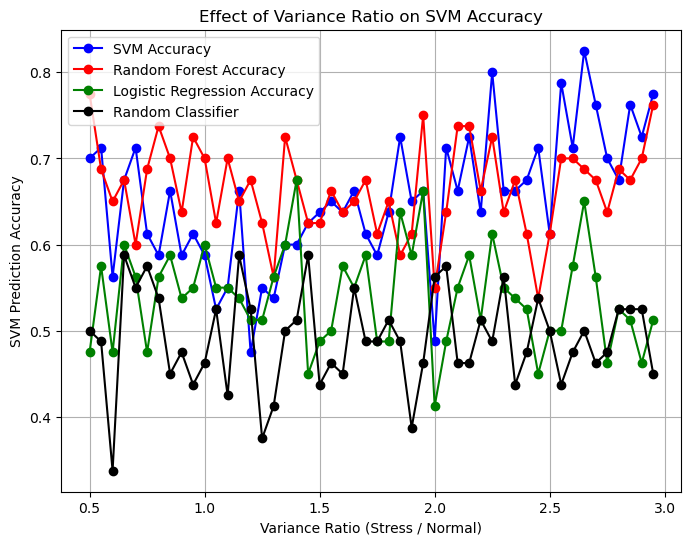

In [ ]:
# Define system parameters
variance_target_normal = 1200.0
variance_ratios = np.arange(0.5, 3.0, 0.05)

# Define activation/deactivation rates for two conditions
sigma_u_stress, sigma_b_stress = 18.0, 0.01  # Stressed Condition
sigma_u_normal, sigma_b_normal = 9.0, 0.02   # Normal Condition
d_stress = d_normal = 1 # Define degradation rates

# Store results
svm_accuracies = []
rf_accuracies = []
log_reg_accuracies = []
random_accuracies = []
variance_ratios_recorded = []

# Iterate over different variance ratios
for ratio in tqdm.tqdm(variance_ratios, desc="Running Variance Ratio Simulations"):
    variance_target_stress = ratio * variance_target_normal  # Adjust stress variance based on ratio

    # Compute transcription rates (rho) for both conditions
    rho_stress = - (sigma_b_stress + sigma_u_stress) * np.sqrt(d_stress + sigma_b_stress + sigma_u_stress) * (
        np.sqrt(sigma_b_stress) * np.sqrt(d_stress + sigma_b_stress + sigma_u_stress) -
        np.sqrt(sigma_b_stress * (sigma_b_stress + sigma_u_stress) + d_stress * (sigma_b_stress + 4 * variance_target_stress * sigma_u_stress))
    ) / (2 * np.sqrt(sigma_b_stress) * sigma_u_stress)

    rho_normal = - (sigma_b_normal + sigma_u_normal) * np.sqrt(d_normal + sigma_b_normal + sigma_u_normal) * (
        np.sqrt(sigma_b_normal) * np.sqrt(d_normal + sigma_b_normal + sigma_u_normal) -
        np.sqrt(sigma_b_normal * (sigma_b_normal + sigma_u_normal) + d_normal * (sigma_b_normal + 4 * variance_target_normal * sigma_u_normal))
    ) / (2 * np.sqrt(sigma_b_normal) * sigma_u_normal)

    # Update parameter sets
    parameter_sets = [
        {"sigma_u": sigma_u_stress, "sigma_b": sigma_b_stress, "rho": rho_stress, "d": d_stress, "label": 0},
        {"sigma_u": sigma_u_normal, "sigma_b": sigma_b_normal, "rho": rho_normal, "d": d_normal, "label": 1},
    ]

    # Set simulation parameters
    time_points = np.arange(0, 500.0, 1.0)  
    size = 200  

    # Run the simulation
    df_results = simulate_two_telegraph_model_systems(parameter_sets, time_points, size)

    # Save dataset for ML classification
    output_file = f"traj_data/mRNA_trajectories_variance_{variance_target_stress}_{variance_target_normal}.csv"
    df_results.to_csv(output_file, index=False)

    # Extract mRNA trajectories
    stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  
    normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  

    # Statistical report
    report = statistical_report(parameter_sets, stress_trajectories, normal_trajectories)

    # Train SVM classifier
    X_train, X_test, y_train, y_test = load_and_split_data(output_file)
    svm_accuracy = svm_classifier(X_train, X_test, y_train, y_test)
    rf_accuracy = random_forest_classifier(X_train, X_test, y_train, y_test)
    log_reg_accuracy = logistic_regression_classifier(X_train, X_test, y_train, y_test)
    random_accuracy = random_classifier(y_test)

    # Record results
    variance_ratios_recorded.append(ratio)
    svm_accuracies.append(svm_accuracy)
    rf_accuracies.append(rf_accuracy)
    log_reg_accuracies.append(log_reg_accuracy)
    random_accuracies.append(random_accuracy)

# Plot Variance Ratio vs SVM Accuracy
plt.figure(figsize=(8, 6))
plt.plot(variance_ratios_recorded, svm_accuracies, marker='o', linestyle='-', color='b', label="SVM Accuracy")
plt.plot(variance_ratios_recorded, rf_accuracies, marker='o', linestyle='-', color='r', label="Random Forest Accuracy")
plt.plot(variance_ratios_recorded, log_reg_accuracies, marker='o', linestyle='-', color='g', label="Logistic Regression Accuracy")
plt.plot(variance_ratios_recorded, random_accuracies, marker='o', linestyle='-', color='k', label="Random Classifier")
plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("SVM Prediction Accuracy")
plt.title("Effect of Variance Ratio on SVM Accuracy")
plt.grid(True)
plt.legend()
plt.show()

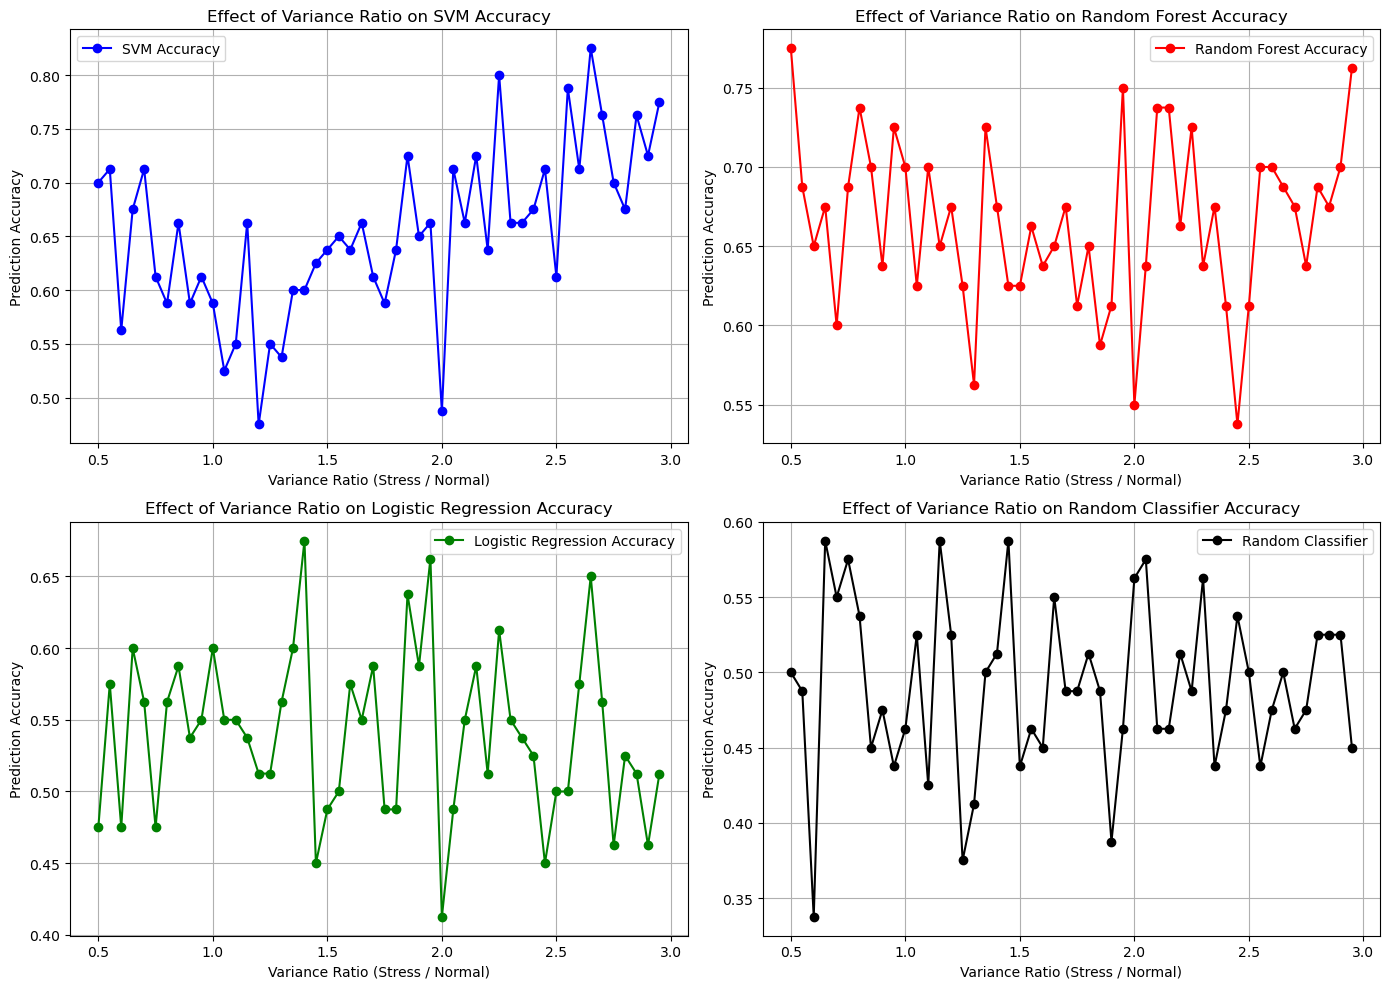

In [6]:
# Plot Variance Ratio vs Prediction Accuracy for different classifiers in subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# SVM Accuracy
axs[0, 0].plot(variance_ratios_recorded, svm_accuracies, marker='o', linestyle='-', color='b', label="SVM Accuracy")
axs[0, 0].set_xlabel("Variance Ratio (Stress / Normal)")
axs[0, 0].set_ylabel("Prediction Accuracy")
axs[0, 0].set_title("Effect of Variance Ratio on SVM Accuracy")
axs[0, 0].grid(True)
axs[0, 0].legend()

# Random Forest Accuracy
axs[0, 1].plot(variance_ratios_recorded, rf_accuracies, marker='o', linestyle='-', color='r', label="Random Forest Accuracy")
axs[0, 1].set_xlabel("Variance Ratio (Stress / Normal)")
axs[0, 1].set_ylabel("Prediction Accuracy")
axs[0, 1].set_title("Effect of Variance Ratio on Random Forest Accuracy")
axs[0, 1].grid(True)
axs[0, 1].legend()

# Logistic Regression Accuracy
axs[1, 0].plot(variance_ratios_recorded, log_reg_accuracies, marker='o', linestyle='-', color='g', label="Logistic Regression Accuracy")
axs[1, 0].set_xlabel("Variance Ratio (Stress / Normal)")
axs[1, 0].set_ylabel("Prediction Accuracy")
axs[1, 0].set_title("Effect of Variance Ratio on Logistic Regression Accuracy")
axs[1, 0].grid(True)
axs[1, 0].legend()

# Random Classifier Accuracy
axs[1, 1].plot(variance_ratios_recorded, random_accuracies, marker='o', linestyle='-', color='k', label="Random Classifier")
axs[1, 1].set_xlabel("Variance Ratio (Stress / Normal)")
axs[1, 1].set_ylabel("Prediction Accuracy")
axs[1, 1].set_title("Effect of Variance Ratio on Random Classifier Accuracy")
axs[1, 1].grid(True)
axs[1, 1].legend()

plt.tight_layout()
plt.show()

## <span style='color:red'> Making the time series difficult to differentiate </span>
<span style = 'color:red'>There may be some out-dated codes and wrong variable assignments in the following code. It is currently under construction. </span>
- The first plot (mRNA mean trajectories) **looks quite similar**, which suggests that on a broad level, both conditions **produce similar mean expression dynamics**.
- However, in the PCA scatter plot, we see **some separation**, meaning SVM **still finds discriminative features**.
Next, I need to synthesise some data that is much more difficult for the SVM to classify. Here are the steps:

### Introduce noise in both conditions
- Increase stochasticity to **blur temporal structure** in classification.

In [ ]:
import numpy as np
import pandas as pd
import tqdm
import multiprocessing

# Define target mean mRNA count (ensuring similarity between conditions)
mu_target = 10.0  

# Define activation/deactivation rates for two conditions
sigma_u_stress, sigma_b_stress = 18.0, 0.01  # Stressed Condition
sigma_u_normal, sigma_b_normal = 9.0, 0.02   # Normal Condition

# Compute corresponding transcription rates (rho) using the given formula
rho_stress = (mu_target * (sigma_u_stress + sigma_b_stress)) / sigma_b_stress
rho_normal = (mu_target * (sigma_u_normal + sigma_b_normal)) / sigma_b_normal

# Define degradation rates (introducing slight stochastic noise)
d_stress = d_normal = 0.12 + np.random.uniform(-0.01, 0.01)

# Updated parameter sets ensuring similar mean mRNA levels
parameter_sets = [
    {"sigma_u": sigma_u_stress, "sigma_b": sigma_b_stress, "rho": rho_stress, "d": d_stress, "label": 0},  # Stressed Condition 
    {"sigma_u": sigma_u_normal, "sigma_b": sigma_b_normal, "rho": rho_normal, "d": d_normal, "label": 1},   # Normal Condition
]

# Set up simulation parameters 
# !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
# 144 time points: to match experimental conditions, where typically a photos is taken every 5 min over 12 hours --> 144 time points

size = 200  # Reduce number of simulations per condition for efficiency

# Run the simulation function
df_results = simulate_two_telegraph_model_systems(parameter_sets, time_points, size)

# Save dataset for ML classification
output_file = f"traj_data/mRNA_trajectories_mean_fixed_{mu_target}_noised.csv"
df_results.to_csv(output_file, index=False)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# report the mean and variance of the mRNA counts at steady state
report = statistical_report(parameter_sets, stress_trajectories, normal_trajectories)

Running simulations on 12 cores...
System 1 parameters: {'sigma_u': 18.0, 'sigma_b': 0.01, 'rho': 18010.000000000004, 'd': 0.11800758340807903, 'label': 0}
System 2 parameters: {'sigma_u': 9.0, 'sigma_b': 0.02, 'rho': 4509.999999999999, 'd': 0.11800758340807903, 'label': 1}


Simulating Systems: 100%|██████████| 2/2 [00:12<00:00,  6.15s/it]


=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 15.0 min):
    - Mean mRNA Count: 108.34
    - Variance: 103184.01

  Normal Condition (after 7.0 min):
    - Mean mRNA Count: 104.56
    - Variance: 49279.06


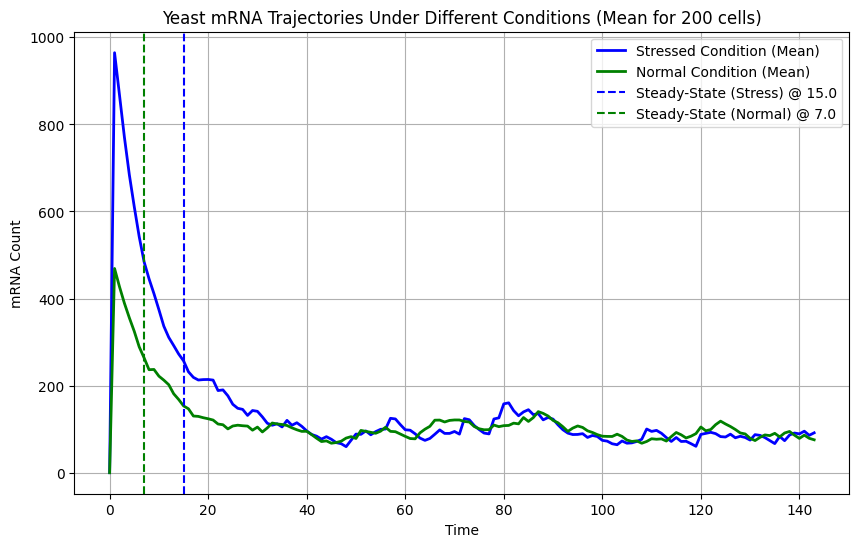

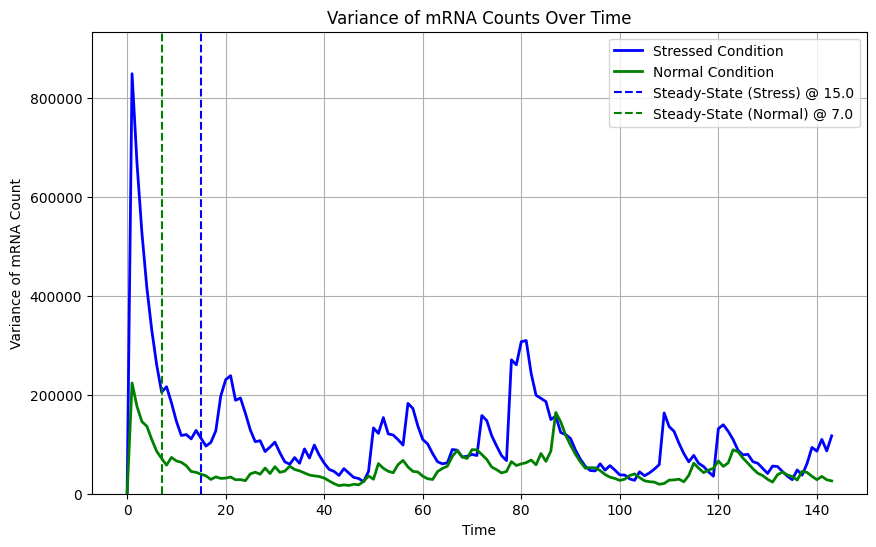


=== Variance at Steady State ===
  Stressed Condition (after 15.0 min): Mean = 105.61, Variance = 99492.65
  Normal Condition (after 7.0 min): Mean = 105.26, Variance = 49360.06


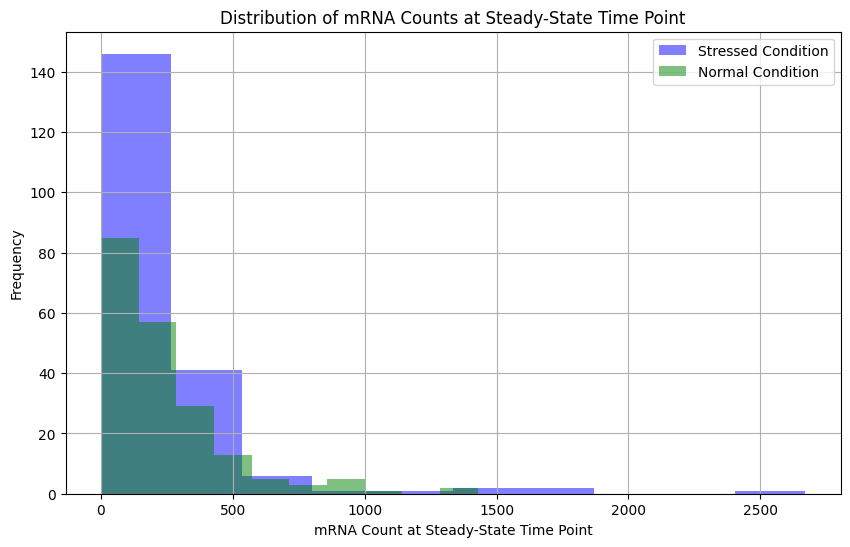

SVM Classification Accuracy: 0.71


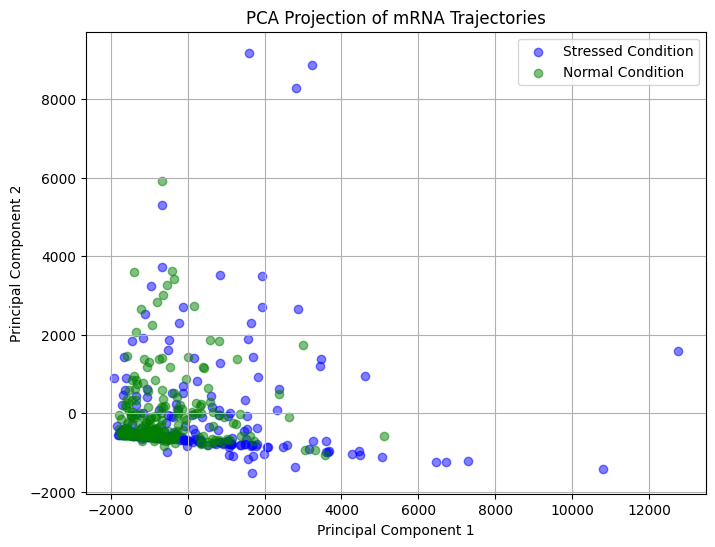

In [10]:
# Plots
plot_mRNA_trajectory(time_points, stress_trajectories, normal_trajectories)
plot_mRNA_variance(time_points, stress_trajectories, normal_trajectories)
plot_mRNA_dist(time_points, stress_trajectories, normal_trajectories)

# Extract features (mRNA trajectories) and labels
X = df_results.iloc[:, 1:].values  # All time series data
y = df_results["label"].values  # Labels: 0 (Stressed Condition) or 1 (Normal Condition)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a basic SVM model without grid search
svm_model = SVC(C=1.0, gamma='scale', kernel='rbf')
svm_model.fit(X_train, y_train)

# Evaluate the model
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Classification Accuracy: {accuracy:.2f}")

# Scatter plot of two PCA components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='blue', label='Stressed Condition', alpha=0.5)
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='green', label='Normal Condition', alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of mRNA Trajectories")
plt.legend()
plt.grid(True)
plt.show()

### Make deactivation and activation rates more similar (with added noise)
Adjust the activation/deactivation rates to be similar but not identical, and introduce a natural variability by deciding the sigma values randomly. 
1. Reduce the difference, but still keep stress conditions distinct:
- The deactivation / activation rates are randomly picked from a uniform distribution, with different conditions being drawn from different ranges. 
- Stressed Condition should still have higher gene deactivation (σ_u) and lower activation (σ_b), normal conditions should maintain more frequent activation.
2. Introduce overlapping stochastic fluctuations as was implemented in the last step

In [2]:
import numpy as np
import pandas as pd
import tqdm
import multiprocessing

# Define target mean mRNA count (ensuring similarity between conditions)
mu_target = 10.0  

# Adjust activation/deactivation rates to make stress and normal conditions similar, but not identical
sigma_u_stress = np.random.uniform(15.0, 20.0)  # Stressed Condition: higher gene deactivation
sigma_b_stress = np.random.uniform(0.008, 0.012)  # Stressed Condition: lower activation

sigma_u_normal = np.random.uniform(8.0, 12.0)  # Normal Condition: lower deactivation
sigma_b_normal = np.random.uniform(0.015, 0.02)  # Normal Condition: higher activation

# Define degradation rates (introducing slight stochastic noise)
d_stress = d_normal = 0.12 + np.random.uniform(-0.01, 0.01)

# Compute corresponding transcription rates (rho) using the given formula
rho_stress = (mu_target * d_stress * (sigma_u_stress + sigma_b_stress)) / sigma_b_stress
rho_normal = (mu_target * d_normal * (sigma_u_normal + sigma_b_normal)) / sigma_b_normal

# Updated parameter sets ensuring similar mean mRNA levels
parameter_sets = [
    {"sigma_u": sigma_u_stress, "sigma_b": sigma_b_stress, "rho": rho_stress, "d": d_stress, "label": 0},  # Stressed Condition 
    {"sigma_u": sigma_u_normal, "sigma_b": sigma_b_normal, "rho": rho_normal, "d": d_normal, "label": 1},   # Normal Condition
]

# Set up simulation parameters 
# !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
# 144 time points: to match experimental conditions, where typically a photos is taken every 5 min over 12 hours --> 144 time points

size = 200  # Reduce number of simulations per condition for efficiency

# Ensure steady state condition is met
for params in parameter_sets:
    if time_points[-1] < 10 / params["d"]:
        time_points = np.linspace(0, 10 / params["d"], int(10 / params["d"] * 10) + 1)

# Initialize storage for results
results = []

# Worker function to run simulations
def run_simulation(param_set):
    sigma_u, sigma_b, rho, d, label = param_set.values()
    population_0 = np.array([1, 0, 0], dtype=int)  # Initial [G, G*, M]

    # Store mRNA trajectories
    samples = np.empty((size, len(time_points)), dtype=int)

    for i in range(size):
        samples[i, :] = gillespie_ssa(
            telegraph_model_propensity, update_matrix, population_0, time_points,
            args=(sigma_u, sigma_b, rho, d))[:, 2]  # Extract mRNA counts

    # Add Gaussian noise to blur temporal structure
    noise_level = 0.1 * np.mean(samples)
    samples += np.random.normal(0, noise_level, samples.shape).astype(int)

    # Save each trajectory as a row with label
    return [[label] + list(trajectory) for trajectory in samples]

num_cores = multiprocessing.cpu_count()  # Get available CPU cores
# Use multiprocessing to accelerate simulations
with multiprocessing.Pool(num_cores) as pool:
    print(f"Running simulations on {num_cores} cores...") 
    results = list(tqdm.tqdm(pool.imap(run_simulation, parameter_sets), total=len(parameter_sets), desc="Simulating Systems"))

# Flatten results
results = [item for sublist in results for item in sublist]

# Convert to DataFrame and save
columns = ["label"] + [f"time_{t}" for t in time_points]
df_results = pd.DataFrame(results, columns=columns)

# Save dataset for ML classification
output_file = "traj_data/mRNA_trajectories_noised_adjusted_sigma.csv"
df_results.to_csv(output_file, index=False)


Running simulations on 12 cores...


Simulating Systems:   0%|          | 0/2 [00:00<?, ?it/s]

Simulating Systems: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]



=== Statistical Report ===
Steady-State Reached: Yes (Stress) | Yes (Normal)

📊 **Steady-State Statistics:**
  Stressed Condition (after 24.0 min):
    - Mean mRNA Count: 11.99
    - Variance: 1482.04

  Normal Condition (after 11.0 min):
    - Mean mRNA Count: 11.88
    - Variance: 780.60


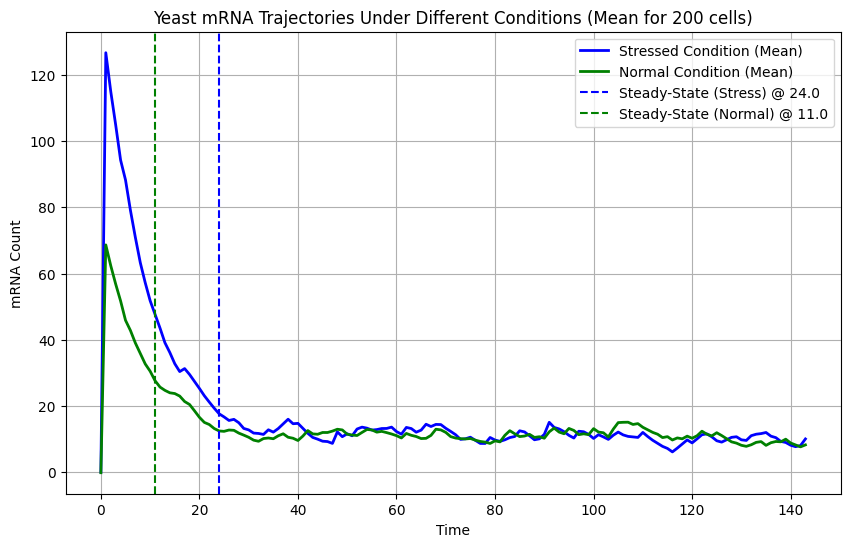

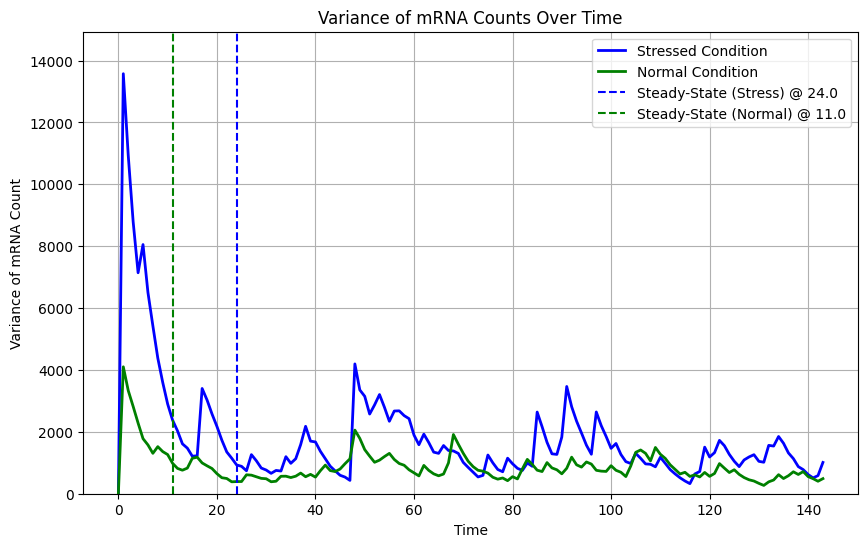


=== Variance at Steady State ===
  Stressed Condition (after 24.0 min): Mean = 11.41, Variance = 1389.42
  Normal Condition (after 11.0 min): Mean = 12.03, Variance = 804.57


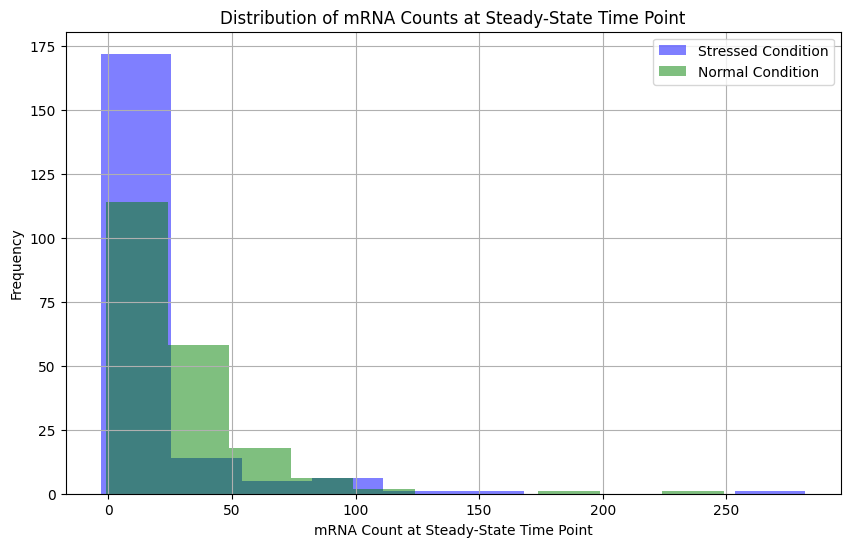

SVM Classification Accuracy: 0.62


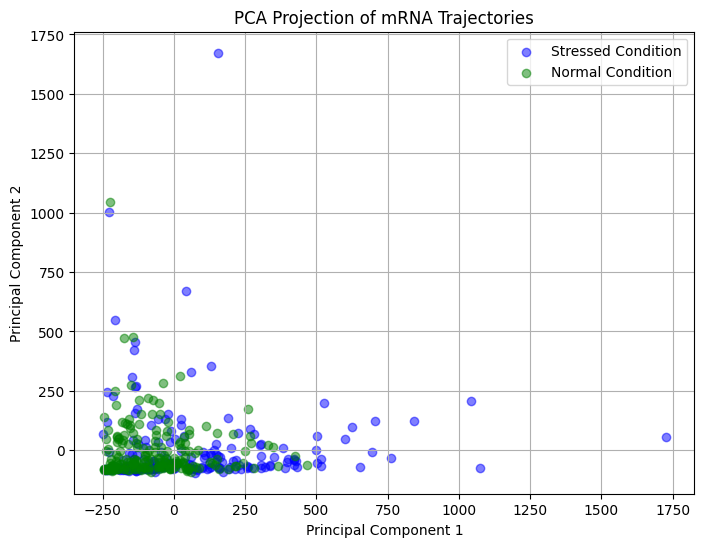

In [ ]:
# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# report the mean and variance of the mRNA counts at steady state
report = statistical_report(parameter_sets, stress_trajectories, normal_trajectories)
# Plots
plot_mRNA_trajectory(time_points, stress_trajectories, normal_trajectories)
plot_mRNA_variance(time_points, stress_trajectories, normal_trajectories)
plot_mRNA_dist(time_points, stress_trajectories, normal_trajectories)

# Extract features (mRNA trajectories) and labels
X = df_results.iloc[:, 1:].values  # All time series data
y = df_results["label"].values  # Labels: 0 (Stressed Condition) or 1 (Normal Condition)

# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a basic SVM model without grid search
svm_model = SVC(C=1.0, gamma='scale', kernel='rbf')
svm_model.fit(X_train, y_train)

# Evaluate the model
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Classification Accuracy: {accuracy:.2f}")

# Scatter plot of two PCA components for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='blue', label='Stressed Condition', alpha=0.5)
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='green', label='Normal Condition', alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of mRNA Trajectories")
plt.legend()
plt.grid(True)
plt.show()